# Random Forest from Scrtach

custom Random Forest model vs Sklearn based Random Forest Model

# 1- Importing key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import math
import numpy as np
import pandas as pd
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# for text analysis
import nltk
import spacy
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
# Modules imported from .py files(decision tree & helper functions ) 
import random
from pprint import pprint
import decision_tree_functions
import helper_functions
from decision_tree_functions import decision_tree_algorithm, decision_tree_predictions
from helper_functions import train_test_split, calculate_accuracy

# 2- Loading data

In [4]:
data=pd.read_csv('Consumer_Complaints.csv')
print(data.shape)
data.head()

(1025010, 19)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18
0,03-12-2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217,NaN
1,10-01-2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10-05-2016,Closed with explanation,Yes,No,2141773,NaN
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100,NaN
3,06-08-2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06-10-2014,Closed with explanation,Yes,Yes,885638,NaN
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760,NaN


In [5]:
data=data[['Product','Consumer Complaint']]

In [6]:
data.isnull().sum()

Product                    0
Consumer Complaint    747196
dtype: int64

In [7]:
data.dropna(subset=['Consumer Complaint'], inplace=True)

In [8]:
data.shape

(277814, 2)

In [9]:
# top 10,000 sample

data=data[:10000]

In [10]:
data.Product.value_counts()

Debt collection                                                                 2415
Mortgage                                                                        1973
Credit reporting                                                                1893
Credit card                                                                     1161
Bank account or service                                                          871
Student loan                                                                     721
Consumer Loan                                                                    554
Payday loan                                                                      101
Money transfers                                                                   97
Prepaid card                                                                      84
Credit reporting, credit repair services, or other personal consumer reports      62
Other financial service                                          

In [11]:
counts=data['Product'].value_counts()
data = data.loc[data['Product'].isin(counts.index[counts > 100])]
data.shape

(9689, 2)

In [12]:
data.shape

(9689, 2)

### 2.1 Data pure

if class==1 then it is trivial to predict that same results

In [5]:
def check_purity(data):
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

### 2.2 Classify

In [6]:
def classify_data(data):
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]

    return classification

### 2.3. Potential splits

In [7]:
def get_potential_splits(data, random_subspace):
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))  # excluding the last column which is the label

    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)

    for column_index in column_indices:
        values = data[:, column_index]
        unique_values = np.unique(values)

        potential_splits[column_index] = unique_values

    return potential_splits

### 2.4. Lowest Overall Entropy

In [8]:

def calculate_entropy(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))

    return entropy


def calculate_overall_entropy(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                       + p_data_above * calculate_entropy(data_above))

    return overall_entropy


def determine_best_split(data, potential_splits):
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value

    return best_split_column, best_split_value

### 2.5.Split data

In [9]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values > split_value]

    # feature is categorical
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]

    return data_below, data_above

### 2.6.Vectorize 

For converting words into numbers

In [37]:
class CustomVectorizer(CountVectorizer):

    # overwrite the build_analyzer method, allowing one to
    # create a custom analyzer for the vectorizer
    def build_analyzer(self):
        # load stop words using CountVectorizer's built in method
        stop_words = self.get_stop_words()

        # create the analyzer that will be returned by this method
        def analyser(doc):
            # load spaCy's model for english language
            spacy.load('en_core_web_md')

            # instantiate a spaCy tokenizer
            lemmatizer = spacy.lang.en.English()

            # apply the preprocessing and tokenzation steps
            doc_clean = unescape(doc).lower()
            tokens = lemmatizer(doc_clean)
            lemmatized_tokens = [token.lemma_ for token in tokens]

            # use CountVectorizer's _word_ngrams built in method
            # to remove stop words and extract n-grams
            return (self._word_ngrams(lemmatized_tokens, stop_words))

        return (analyser)
custom_vec = CustomVectorizer(ngram_range=(1,2),
                              stop_words='english')

In [36]:
def tfidf(text_documents):
    word_tf_values = {}
    for token in most_freq:
        sent_tf_vector = []
        for document in corpus:
            doc_freq = 0
            for word in nltk.word_tokenize(document):
                if token == word:
                      doc_freq += 1
            word_tf = doc_freq/len(nltk.word_tokenize(document))
            sent_tf_vector.append(word_tf)
        word_tf_values[token] = sent_tf_vector
    return text_documents

# 3- Random Forest:Custom Model 

using custom code

### 3.1.decision tree with random subsamples

In [19]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df

        # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)

        return classification


    # recursive part
    else:
        counter += 1

        # helper functions
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification

        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)

        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)

        # instantiate sub-tree
        sub_tree = {question: []}

        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)

        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree

In [24]:
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

### 3.2. Bootstrap

Also random forest initialization with key parameter

In [7]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

### 3.3. Predict results

In [25]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

### 3.4.predict random decision tree

these random trees with multiple brances are creating random forest.

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
train = tfidf.fit_transform(data.clean).toarray()
labels = data['dep'].astype(str)
forest = random_forest_algorithm(train_df, n_trees=2000, n_bootstrap=1600, n_features=1000, dt_max_depth=400)
# we are using entropy as of impurity calculator
predictions = random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.label)
print(accuracy)

0.5804924242424242


- **bootstrap** is for randomly choosing samples. Some samples can even occur multiple times as it is random selection.In our case we shall choose 1600 out of 3200 almost half of overall data samples
- **Random subspace**(added in decision tree) is random selection of features i.e our columns. So n_feature represents random sub-space.Out of total 4820 features, we have choosen a set a trees with 1000 random features. Hence, both rows and columns are now shuffled randomly.
- **number of trees** (added in random_forest_algorithm function) are trees that are made from above random rows and columns. We shall make 2000 trees composed of random rows and random columns.
- **max_depth** is the depth to which trees will make layers. For example , 400 layers mean a hiearchy of 400 steps/levels down the way till a classification output is finalized.


all these parameters have come after testing and checking best accuracy score with multiple combination. Scikit learn provides these best parameters after "Model Tune".

# 4-Random Forest:sklearn

In [13]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
data['category_id'] = data['Product'].factorize()[0]
from io import StringIO
category_id_df = data[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [15]:
data.head(3)

,Product,Consumer Complaint,category_id
1,Credit reporting,I have outdated information on my credit repor...,0
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,1
7,Credit reporting,An account on my credit report has a mistaken ...,0


In [16]:
data.Product.value_counts()

Debt collection            2415
Mortgage                   1973
Credit reporting           1893
Credit card                1161
Bank account or service     871
Student loan                721
Consumer Loan               554
Payday loan                 101
Name: Product, dtype: int64

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(data['Consumer Complaint']).toarray()
labels = data.category_id
features.shape

(9689, 47952)

In [18]:
target=data['Product'].astype(str)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=0.25)

In [20]:
print(("Shape of train vectorizated data ="),x_train.shape)
print(("Shape of test vectorizated data ="),x_test.shape)
print(("Shape of train target data ="),y_train.shape)
print(("Shape of test target data ="),y_test.shape)

Shape of train vectorizated data = (7266, 47952)
Shape of test vectorizated data = (2423, 47952)
Shape of train target data = (7266,)
Shape of test target data = (2423,)


In [21]:
sklearn_clf = RandomForestClassifier()
sklearn_clf.fit(x_train, y_train)
y_pred = sklearn_clf.predict(x_test)
accuracy=accuracy_score(y_test, y_pred)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.768881551795295


- 58.04 by custom model
- 76.88 by sklearn random model

### cross validation 

For tackling issue of random samples and random results created due to that.

In [22]:
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(),   
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, target, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [23]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.788958
1,RandomForestClassifier,1,0.770898
2,RandomForestClassifier,2,0.770898
3,RandomForestClassifier,3,0.782766
4,RandomForestClassifier,4,0.775942


In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
RandomForestClassifier    0.777892
Name: accuracy, dtype: float64

# 5- Model Evaluation

In [25]:
print(y_test.shape)
print(y_pred.shape)

(2423,)
(2423,)


In [26]:
y_test.value_counts()

Debt collection            630
Mortgage                   503
Credit reporting           467
Credit card                259
Bank account or service    217
Student loan               175
Consumer Loan              138
Payday loan                 34
Name: Product, dtype: int64

### 5a. classification Report

In [28]:
data['Product'].unique()

array(['Credit reporting', 'Consumer Loan', 'Debt collection', 'Mortgage',
       'Credit card', 'Bank account or service', 'Student loan',
       'Payday loan'], dtype=object)

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=data['Product'].unique()))

                         precision    recall  f1-score   support

       Credit reporting       0.85      0.73      0.79       217
          Consumer Loan       0.81      0.12      0.21       138
        Debt collection       0.81      0.71      0.76       259
               Mortgage       0.73      0.82      0.77       467
            Credit card       0.72      0.84      0.78       630
Bank account or service       0.79      0.90      0.84       503
           Student loan       0.00      0.00      0.00        34
            Payday loan       0.89      0.77      0.83       175

               accuracy                           0.77      2423
              macro avg       0.70      0.61      0.62      2423
           weighted avg       0.77      0.77      0.75      2423



### 5b.Confusion matrix

In [31]:
confusion_matrix(y_test, y_pred)

array([[159,   0,  17,  11,  18,  12,   0,   0],
       [  5,  17,   9,  20,  37,  46,   0,   4],
       [  7,   0, 184,  23,  35,  10,   0,   0],
       [  0,   2,   8, 384,  54,  16,   0,   3],
       [  7,   2,   7,  65, 529,  12,   0,   8],
       [  6,   0,   1,  15,  26, 455,   0,   0],
       [  1,   0,   1,   3,  18,  10,   0,   1],
       [  1,   0,   1,   7,  18,  13,   0, 135]], dtype=int64)

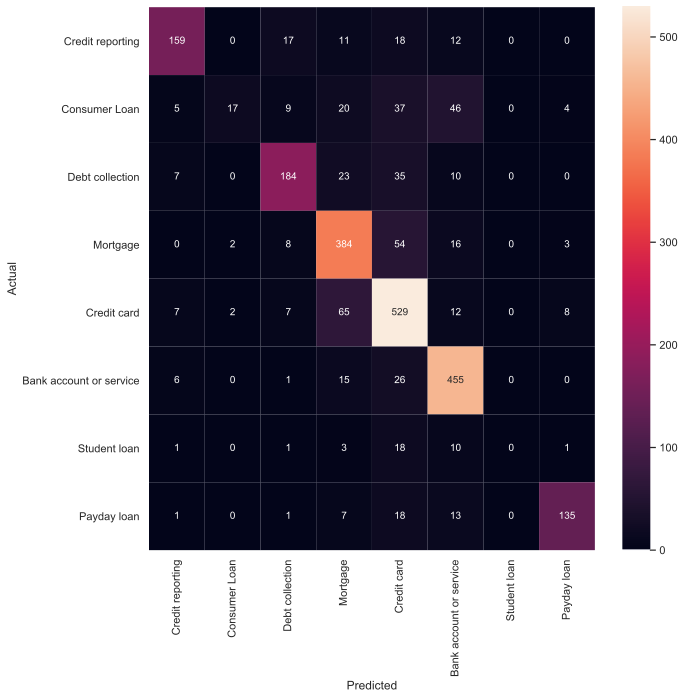

In [32]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Precision is the fraction of correct positives among the total predicted positives. It is also called the accuracy of positive predictions.

    Precision ={TP}/{TP + FP}]

Recall is the fraction of correct positives among the total positives in the dataset. It is indicating how many total positives of the actual dataset were covered(classified correctly) while doing prediction.

    Recall ={TP}/{TP + FN}]
  
  
F1 is communlative effect of both recall and precision

    F1 = 2 * (precision * recall) / (precision + recall)

**Next stage is to train model on full dataset and deploy it on running in service.**